In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import torch
import numpy as np 
import matplotlib.pyplot as plt
from skimage.util import montage
from recoMRD import recoMRD
from bart import bart

def plot_mosaic(img:np.ndarray, cmap='turbo', clim=None, grid_shape=None, title=None, transpose=False):
    img = np.squeeze(np.abs(img)) 
    if img.ndim > 3:
        print(f'Error! plot_mosaic expects 3D data but it is {img.ndim}D')
        return
    img = np.moveaxis(img,-1,0)
    img = montage(img, fill=0, grid_shape=grid_shape)
    if transpose:
        img = img.T
    
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation='nearest', clim=clim)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.colorbar()
    plt.tight_layout() 
    return img

def plot3D(img:np.ndarray, cmap='turbo', clim=None, pos = None):
    img = img.squeeze()
    if pos is None:
        pos = [x//2 for x in img.shape[0:3]]
        
    plt.figure()
    plt.subplot(131)
    plt.imshow(img[:,:,pos[2]], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img[:,pos[1],:], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(img[pos[0],:,:], cmap=cmap, interpolation='nearest', origin='lower',clim=clim)
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout() 


In [2]:
filename = './../example_data/meas_MID00039_FID03618_localizer2D_iPAT2x1_interleaved.mrd'
mrd = recoMRD(filename)

kspace_osremoved = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
img_sos = mrd.coil_combination(kspace_osremoved, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 192
Number of image     scans: 768
k-space size in protocol: 384 x 192 x 1
image   size in protocol: 192 x 192 x 1
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled array size=[16, 384, 192, 1, 8, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[16, 384, 24, 1, 8, 1, 1, 1, 1, 1, 1]: 100%|██████████| 192/192 [00:00<00:00, 13152.15it/s]
Filling noise     , size=[16, 384, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1/1 [00:00<00:00, 2487.72it/s]
Filling image_scan, size=[16, 384, 96, 1, 8, 1, 1, 1, 1, 1, 1]:   0%|          | 0/768 [00:00<?, ?it/s]

Filling image_scan, size=[16, 384, 96, 1, 8, 1, 1, 1, 1, 1, 1]: 100%|██████████| 768/768 [00:00<00:00, 7754.55it/s]

Reorder slice... 

Done.
Removing oversampling...
Done.
Combining coils (sos)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 545.97it/s]

3.5762786865234375e-06
Done.


torch.Size([192, 192, 8])


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


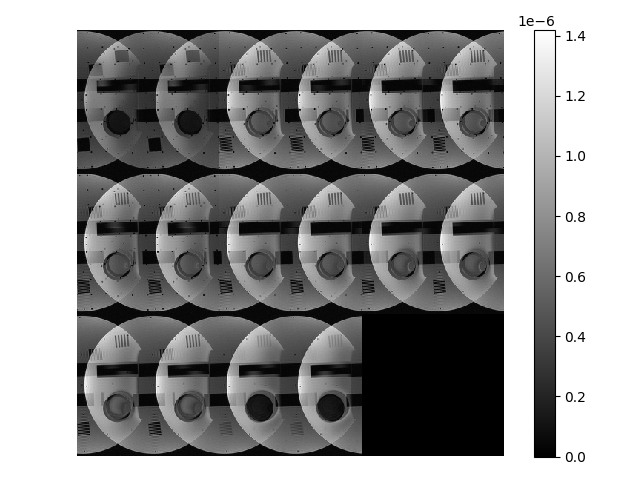

In [3]:
print(img_sos.squeeze().shape)
temp = img_sos.squeeze().numpy()
temp = plot_mosaic(temp, cmap='gray')

(384, 192, 8)
Acceleration Factor: R=2.00


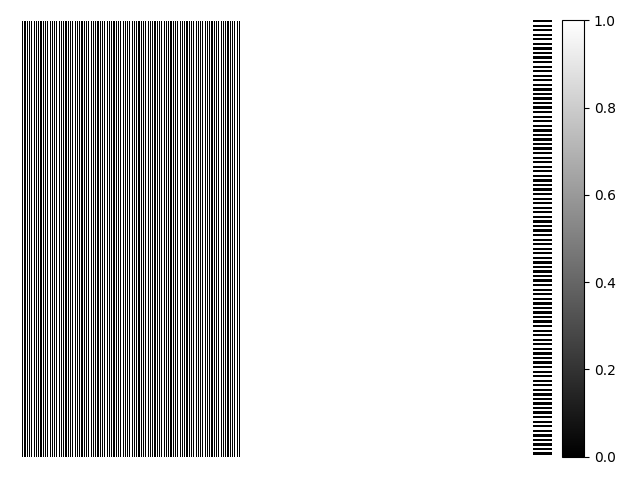

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].select(0, mrd.dim_info['cha']['ind']).squeeze().numpy() # take the first coil
mask = bart.bart(1, 'pattern', temp).real > 0
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
plot3D(mask, clim=[0, 1], cmap='gray')
print('Acceleration Factor: R={:.2f}'.format(R))

(384, 192, 16)


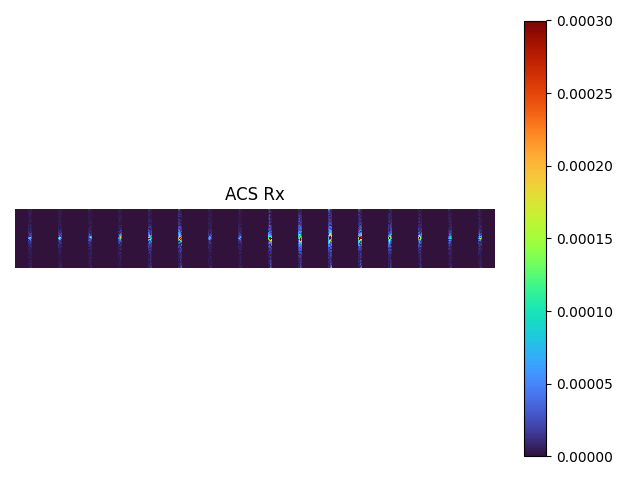

In [5]:
# show some Rx channels from reference scan
slc  = mrd.dim_info['slc']
temp = mrd.kspace['acs'].index_select(slc['ind'], torch.Tensor([slc['len']//2]).int()).moveaxis(mrd.dim_info['cha']['ind'], -1).abs().squeeze().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [1, temp.shape[2]], clim=[0, 3e-4], title='ACS Rx')

Removing oversampling...
Done.
Combining coils (sos)... 


Fourier transform:   0%|          | 0/16 [00:00<?, ?it/s]

Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 674.33it/s]

4.291534423828125e-06
Done.
torch.Size([1, 192, 192, 1, 8, 1, 1, 1, 1, 1, 1])
torch.Size([192, 192, 8])


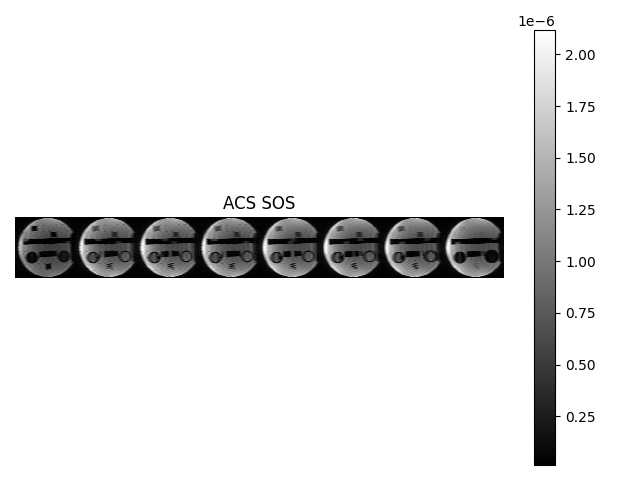

In [6]:
# sum of square of reference scan
acs = mrd.remove_oversampling(mrd.kspace['acs'], is_kspace=True)
acs_img = mrd.coil_combination(acs, method='sos')

temp = acs_img.squeeze()
print(acs_img.shape)
print(temp.shape)
temp = plot_mosaic(temp.numpy(), grid_shape = [1, temp.shape[2]], cmap='gray', title='ACS SOS')


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity_espirit = mrd.calc_coil_sensitivity(acs, method='espirit')
print(coils_sensitivity_espirit.shape)

Computing coil sensitivity...


Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
torch.Size([16, 192, 192, 1, 8, 1, 1, 1, 1, 1, 1])
CPU times: user 311 ms, sys: 224 ms, total: 535 ms
Wall time: 2.58 s


In [8]:
%%time
# use caldir method to get coil sensitivity 
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(acs, method='caldir')
print(coils_sensitivity_caldir.shape)

Computing coil sensitivity...
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Calibration region 96x24x1
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
torch.Size([16, 192, 192, 1, 8, 1, 1, 1, 1, 1, 1])
CPU times: user 320 ms, sys: 205 ms, total: 525 ms
Wall time: 279 ms


torch.Size([32, 192, 192, 1, 1, 1, 1, 1, 1, 1, 1])
(192, 192, 32)


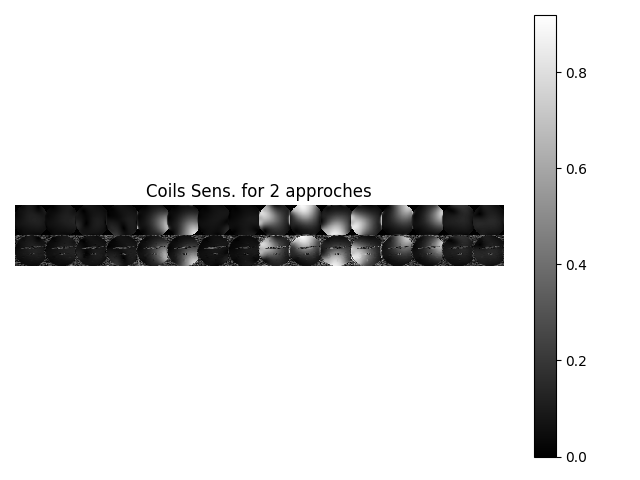

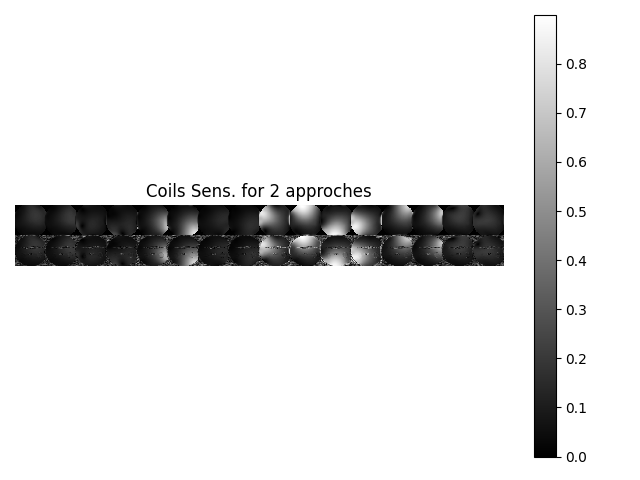

In [9]:
temp = torch.cat((coils_sensitivity_espirit, coils_sensitivity_caldir), dim = mrd.dim_info['cha']['ind']).index_select(mrd.dim_info['slc']['ind'], torch.Tensor([0]).int()).abs()
print(temp.shape)
temp = temp.moveaxis(mrd.dim_info['cha']['ind'], -1).squeeze().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [2, temp.shape[2]//2], cmap='gray', title='Coils Sens. for 2 approches')

temp = torch.cat((coils_sensitivity_espirit, coils_sensitivity_caldir), dim = mrd.dim_info['cha']['ind']).index_select(mrd.dim_info['slc']['ind'], torch.Tensor([mrd.dim_info['slc']['len']-1]).int()).abs()
temp = temp.moveaxis(mrd.dim_info['cha']['ind'], -1).squeeze().numpy()
temp = plot_mosaic(temp, grid_shape = [2, temp.shape[2]//2], cmap='gray', title='Coils Sens. for 2 approches')

Removing oversampling...
Done.
Combining coils (bart)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 652.16it/s]

GPU reconstruction
Size: 294912 Samples: 147456 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.477246
1.7778995037078857
Done.
Combining coils (bart)... 


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 645.90it/s]


GPU reconstruction
Size: 294912 Samples: 147456 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.449851
1.7425506114959717
Done.
(192, 192, 16)


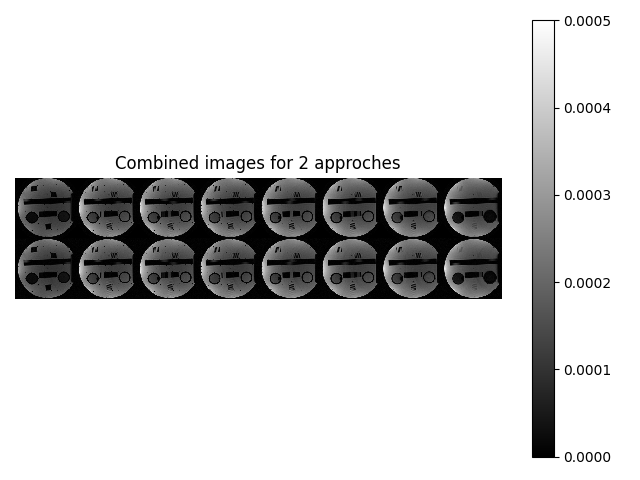

In [10]:
img = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
volume_comb_espirit = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_espirit)
volume_comb_caldir  = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir)
temp = torch.cat((volume_comb_espirit, volume_comb_caldir), dim = mrd.dim_info['slc']['ind']).squeeze().abs().numpy()
print(temp.shape)
temp = plot_mosaic(temp, grid_shape = [2, temp.shape[2]//2], cmap='gray', clim = [0, 5e-4], transpose = False, title='Combined images for 2 approches')
